In [8]:
import tensorflow as tf
import os, os.path
import pandas as pd
import numpy as np
from numpy import ndarray
import skimage
from skimage import data, io, filters
from scipy import ndimage
print('imported')
import matplotlib.pyplot as plt 



TESTING_DIR = os.getcwd() + '/data/training'
TRAINED_MODEL = os.getcwd() + '/output/'

imported


In [9]:
def load_data(TESTING_DIR):
    images = []
    labels = []
    directories = [d for d in os.listdir(TESTING_DIR) 
                if os.path.isdir(os.path.join(TESTING_DIR, d))]

    # Traverse through each directory and make a list
    # of files names if they end in the PNG format
    for d in directories:
        label_directory = os.path.join(TESTING_DIR, d)
        file_names = [os.path.join(label_directory, f) 
                        for f in os.listdir(label_directory) 
                          if f.endswith(".png")]
        #Traverse through each file, add the image data
        # and label to the 2 lists
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))

    return images, labels

images, labels = load_data(TESTING_DIR)
print('images and labels loaded...')




images and labels loaded...


In [10]:
from skimage import transform, exposure

print('Down scaling images...')
images = [transform.resize(image, (50, 50)) for image in images]

Down scaling images...


C:\Users\aaron\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
def random_sample(images, labels):
    import matplotlib.pyplot as plt
    import random

    #Randomly Select 10 images 10 correlating labels
    # and store them in a new list for testing
    sample_indexes = random.sample(range(len(images)), 10)
    sample_images = [images[i] for i in sample_indexes]
    sample_labels = [labels[i] for i in sample_indexes]

#     sample_images = np.array(sample_images).astype(float)

    return sample_images, sample_labels



In [19]:
x = tf.placeholder(dtype = tf.float32, shape = [None, 50, 50])
y = tf.placeholder(dtype = tf.int32, shape = [None])

# Extract features
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') #move one pixel at s time

#
def maxpool2d(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #pool 2 pixels at a time


def convolutional_network(x):
    weights = {
        'weights_conv1' : tf.Variable(tf.random_normal([5,5,1,64])),
        'weights_conv2' : tf.Variable(tf.random_normal([5,5,64,128])),
        'weights_conv3' : tf.Variable(tf.random_normal([5,5,128,256])),
        'weights_fully_con' : tf.Variable(tf.random_normal([7*7*256,4096])),
        'weights_out' : tf.Variable(tf.random_normal([4096, 6]))
    }

    biases = {
        'bias_conv1' : tf.Variable(tf.random_normal([64])),
        'bias_conv2' : tf.Variable(tf.random_normal([128])),
        'bias_conv3' : tf.Variable(tf.random_normal([256])),
        'bias_fully_con' : tf.Variable(tf.random_normal([4096])),
        'bias_out' : tf.Variable(tf.random_normal([6]))
    }

    x = tf.reshape(x, shape=[-1, 50, 50, 1])

    # 3 comvolutional and 3 max pooling layers
    conv1 = tf.nn.relu(conv2d(x, weights['weights_conv1']) + biases['bias_conv1'])
    conv1 = maxpool2d(conv1)

    conv2 = tf.nn.relu(conv2d(conv1, weights['weights_conv2']) + biases['bias_conv2'])
    conv2 = maxpool2d(conv2)

    conv3 = tf.nn.relu(conv2d(conv2, weights['weights_conv3']) + biases['bias_conv3'])
    conv3 = maxpool2d(conv3)

    # The fully connected layer
    fully_con = tf.reshape(conv3, [-1, 7*7*256])
    fully_con = tf.nn.relu(tf.matmul(fully_con, weights['weights_fully_con']) + biases['bias_fully_con'])
    # fc = tf.nn.dropout(fully_con, keep_rate) # Apply dropout

    output = tf.matmul(fully_con, weights['weights_out']) + biases['bias_out']
    return output


INFO:tensorflow:Restoring parameters from C:\Users\aaron\Desktop\model-training-tensorflow/output/trained_model.ckpt
session restored...
Correct Labels:  [3, 5, 4, 5, 3, 5, 3, 5, 2, 5]
Predicted Labels:  [4 3 4 4 4 4 4 3 4 4]


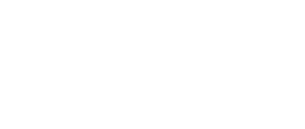

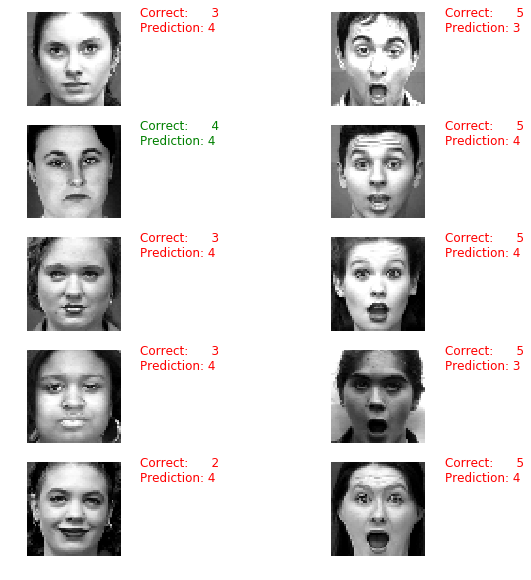

In [32]:
sample_images = []
sample_labels = []



def test_network(x, images, labels):
    sample_images, sample_labels = random_sample(images, labels)
    sample_images = np.array(sample_images).astype(float)
    
    
    pred = convolutional_network(x)
    correct_pred = tf.argmax(pred, 1)

    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(TRAINED_MODEL + 'trained_model.ckpt.meta')
        saver.restore(sess, TRAINED_MODEL + 'trained_model.ckpt' )
        print('session restored...')
        
        predicted = sess.run(correct_pred, feed_dict={x: sample_images})
 
        print('Correct Labels: ', sample_labels)
        print('Predicted Labels: ', predicted)

        
        #Plot the images samples in a grid with the predicted
        #outputs and the true outputs
        fig = plt.figure(figsize=(10, 10))
        for i in range(len(sample_images)):
            truth = sample_labels[i]
            prediction = predicted[i]
            plt.subplot(5, 2,1+i)
            plt.axis('off')
            color='green' if truth == prediction else 'red'
            plt.text(60, 10, "Correct:      {0}\nPrediction: {1}".format(truth, prediction), 
                     fontsize=12, color=color)
            plt.imshow(sample_images[i], cmap='gray')
        plt.show() 
        
        
test_network(x, images, labels)